# TensorFlow2 DenseNet-BiLSTM-RGB

## 1.导入数据
使用BROOK数据集 

In [6]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import accuracy_score
from tensorflow import keras
from PIL import Image
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
import matplotlib.colors as colors
import tensorflow_addons as tfa
import os.path 
from tensorflow_addons.layers import CRF

In [7]:
#txt_file = 'hr/train19.txt'
txt_file = 'dataset/speedtxt/train.txt'
f = open(txt_file)
imgspaths = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspaths.append(filename)
        speeds.append(int(speed))
    
y_train = np.array(speeds)



In [8]:
max_unit = np.max(y_train)

In [10]:
# txt_file = 'hr/test19.txt'
txt_file = 'dataset/speedtxt/test.txt'
f = open(txt_file)
imgspath2 = []
speeds = []
for line in f.readlines():
    filename = line.split(',')[0]
    speed = line.split(',')[1]
    if speed[-1] == '\n':
        speed = speed[:-1]
        imgspath2.append(filename)
        speeds.append(int(speed))
y_test = np.array(speeds)
        

In [11]:
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg','1565751556968.jpg']
# imgspaths = ['1565751556792.jpg','1565751556904.jpg','1565751562024.jpg']
# y_train = [[53],[54],[55]]
x_train = []
for imgspath in imgspaths:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_train.append(img)
x_train = np.array(x_train)

In [12]:
# imgspath2 = ['1565752827880.jpg']
# y_test = [[55]]
x_test = []
for imgspath in imgspath2:
    path1 = 'dataset/train/'+imgspath
    path2 = 'dataset/test/'+imgspath
    path3 = 'dataset/val/'+imgspath
    path4 = '../Model-Training2/dataset/train/'+imgspath
    path5 = '../Model-Training2/dataset/test/'+imgspath
    path6 = '../Model-Training2/dataset/val/'+imgspath
    if os.path.exists(path1):
        img = np.array(Image.open(path1))
    elif os.path.exists(path2):
        img = np.array(Image.open(path2))
    elif os.path.exists(path3):
        img = np.array(Image.open(path3))
    elif os.path.exists(path4):
        img = np.array(Image.open(path4))
    elif os.path.exists(path5):
        img = np.array(Image.open(path5))
    else:
        img = np.array(Image.open(path6))
        
#     img = colors.rgb_to_hsv(img)
    img = cv2.resize(img,(32,32))
    x_test.append(img)
x_test = np.array(x_test)

In [13]:
y_train = keras.utils.to_categorical(y_train)
y_test = keras.utils.to_categorical(y_test)

In [14]:
validation_set = (x_test, y_test)

## CNN和LSTM结果合并

In [15]:
from tensorflow.keras import layers
model = keras.Sequential()

In [16]:
x_shape = x_train.shape
cnet2 = DenseNet201(
    input_shape=(x_shape[1], x_shape[2], x_shape[3]),
    weights='imagenet',
    include_top=False
)
cnet2.trainable = True
img_input = layers.Input(shape=(x_shape[1], x_shape[2], x_shape[3]))
base_model = cnet2(img_input)

# pool = layers.GlobalAveragePooling2D()(final_layer)
flat = layers.Flatten()(base_model)
dense1 = layers.Dense(64)(flat)

74850304/74836368 [==============================] - 19s 0us/step


In [17]:
reshape = layers.Reshape(target_shape=(x_shape[1]*x_shape[2], x_shape[3]))(img_input)
lstm_layer = layers.Bidirectional(keras.layers.LSTM(50, return_sequences=False))(reshape)
dense2 = layers.Dense(64)(lstm_layer)

In [18]:
merged_layer = layers.concatenate([dense1, dense2])
# merged_layer = dense1
outt = layers.Dense(max_unit+1,activation='softmax')(merged_layer)
model = keras.Model(inputs=img_input, outputs=outt)
model.compile(optimizer=keras.optimizers.Adam(),
             loss=keras.losses.CategoricalCrossentropy(),
             metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 densenet201 (Functional)       (None, 1, 1, 1920)   18321984    ['input_2[0][0]']                
                                                                                                  
 reshape (Reshape)              (None, 1024, 3)      0           ['input_2[0][0]']                
                                                                                                  
 flatten (Flatten)              (None, 1920)         0           ['densenet201[0][0]']            
                                                                                              

In [19]:
%%time
history2 = model.fit(x_train, y_train, batch_size=64,epochs=100, validation_data = validation_set)

Epoch 1/100
850/850 [==============================] - 2225s 3s/step - loss: 2.4091 - accuracy: 0.4305 - val_loss: 2.3176 - val_accuracy: 0.4369
Epoch 2/100
850/850 [==============================] - 2131s 3s/step - loss: 2.0362 - accuracy: 0.4706 - val_loss: 2.2112 - val_accuracy: 0.4431
Epoch 3/100
850/850 [==============================] - 2483s 3s/step - loss: 1.8488 - accuracy: 0.4889 - val_loss: 3.1887 - val_accuracy: 0.3005
Epoch 4/100
850/850 [==============================] - 2640s 3s/step - loss: 1.7950 - accuracy: 0.4970 - val_loss: 2.1402 - val_accuracy: 0.4503
Epoch 5/100
850/850 [==============================] - 2409s 3s/step - loss: 1.7801 - accuracy: 0.4991 - val_loss: 1.9703 - val_accuracy: 0.4742
Epoch 6/100
850/850 [==============================] - 2380s 3s/step - loss: 1.5866 - accuracy: 0.5263 - val_loss: 1.8057 - val_accuracy: 0.4893
Epoch 7/100
850/850 [==============================] - 2361s 3s/step - loss: 1.4812 - accuracy: 0.5437 - val_loss: 1.9987 - val_ac

850/850 [==============================] - 2476s 3s/step - loss: 0.2797 - accuracy: 0.9029 - val_loss: 2.0366 - val_accuracy: 0.6117
Epoch 58/100
850/850 [==============================] - 2410s 3s/step - loss: 0.2521 - accuracy: 0.9118 - val_loss: 1.9622 - val_accuracy: 0.6148
Epoch 59/100
850/850 [==============================] - 2415s 3s/step - loss: 0.2567 - accuracy: 0.9119 - val_loss: 2.6526 - val_accuracy: 0.5696
Epoch 60/100
850/850 [==============================] - 2476s 3s/step - loss: 0.2490 - accuracy: 0.9122 - val_loss: 2.1069 - val_accuracy: 0.6244
Epoch 61/100
850/850 [==============================] - 2519s 3s/step - loss: 0.2421 - accuracy: 0.9155 - val_loss: 1.9030 - val_accuracy: 0.6251
Epoch 62/100
850/850 [==============================] - 2441s 3s/step - loss: 0.2319 - accuracy: 0.9186 - val_loss: 1.9393 - val_accuracy: 0.6274
Epoch 63/100
850/850 [==============================] - 2433s 3s/step - loss: 0.2295 - accuracy: 0.9201 - val_loss: 1.9352 - val_accuracy

In [20]:
model.evaluate(x=x_test, y=y_test,verbose=1)

224/224 [==============================] - 82s 342ms/step - loss: 2.2365 - accuracy: 0.6607


[2.2365236282348633, 0.6607142686843872]

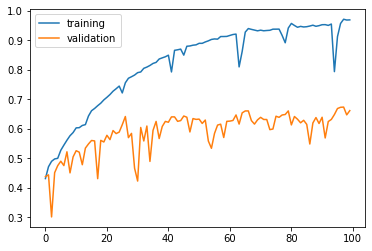

In [21]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

In [22]:
np.max(history2.history['accuracy'])

0.970404863357544

In [23]:
np.max(history2.history['val_accuracy'])

0.6727120280265808